# In the Name of God
## Deep Learning HW2 - Problem 3
## Sayed Pouria fatemi 400206324

In [ ]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
import seaborn
from torch.utils.data import Dataset , DataLoader
from torchvision.io import read_image
import torchvision.transforms as T

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
training_data = pd.read_csv("/content/drive/My Drive/Data/HW2_data/Q3_train.csv")
test_data = pd.read_csv("/content/drive/My Drive/Data/HW2_data/Q3_test.csv")
training_data

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,3,107,118,127,134,139,143,146,150,153,...,207,207,207,207,206,206,206,204,203,202
1,6,155,157,156,156,156,157,156,158,158,...,69,149,128,87,94,163,175,103,135,149
2,2,187,188,188,187,187,186,187,188,187,...,202,201,200,199,198,199,198,195,194,195
3,2,211,211,212,212,211,210,211,210,210,...,235,234,233,231,230,226,225,222,229,163
4,13,164,167,170,172,176,179,180,184,185,...,92,105,105,108,133,163,157,163,164,179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27450,13,189,189,190,190,192,193,193,193,193,...,132,165,99,77,52,200,234,200,222,225
27451,23,151,154,157,158,160,161,163,164,166,...,198,198,198,198,198,196,195,195,195,194
27452,18,174,174,174,174,174,175,175,174,173,...,121,196,209,208,206,204,203,202,200,200
27453,17,177,181,184,185,187,189,190,191,191,...,119,56,27,58,102,79,47,64,87,93


##Part (a)

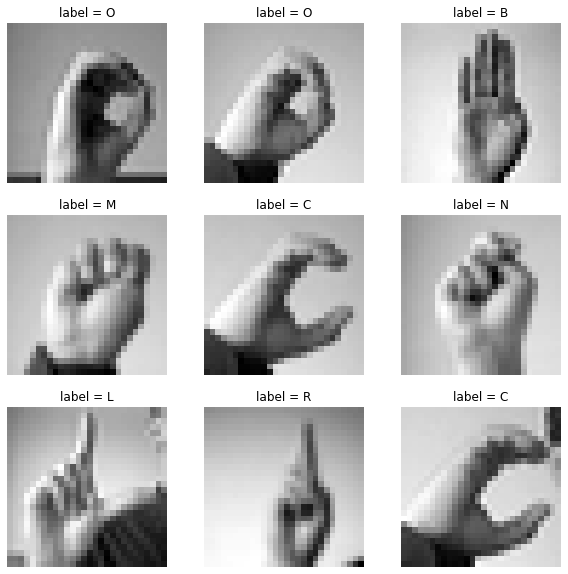

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(10, 10))

for i in range(3):
  for j in range(3):  
    sample = training_data.sample()
    label = int(sample['label'])
    img = sample.drop('label', axis=1).to_numpy()
    img = img.reshape(28, 28)
    ax[i][j].axis(False)
    ax[i][j].imshow(img, cmap="gray")
    ax[i][j].set_title('label = ' + chr(label + 65))

fig.show()

##Part (b)

In [ ]:
training_data = training_data.sample(frac=1)
train_df = training_data[: int(0.75 * len(training_data))]
validation_df = training_data[int(0.75 * len(training_data)):]

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None, target_transform=None):
        self.data = dataframe.drop('label', axis=1)
        self.labels = dataframe["label"]
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        X = torch.tensor(self.data.iloc[idx]).to(device).float()
        Y = torch.tensor(self.labels.iloc[idx]).to(device)
        if self.transform:
            X = self.transform(X)
        if self.target_transform:
            Y = self.target_transform(Y)
        return X, Y

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, Dropout=False):
        super(NeuralNetwork, self).__init__()
        if Dropout:
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(784, 500),
              nn.ReLU(),
              nn.Linear(500, 200),
              nn.Dropout(p=0.5),
              nn.ReLU(),
              nn.Linear(200, 100),
              nn.Dropout(p=0.5),
              nn.ReLU(),
              nn.Linear(100, 100),
              nn.ReLU(),
              nn.Linear(100, 50),
              nn.ReLU(),
              nn.Linear(50, 25),
          )
        else:
          self.linear_relu_stack = nn.Sequential(
              nn.Linear(784, 500),
              nn.ReLU(),
              nn.Linear(500, 200),
              nn.ReLU(),
              nn.Linear(200, 100),
              nn.ReLU(),
              nn.Linear(100, 100),
              nn.ReLU(),
              nn.Linear(100, 50),
              nn.ReLU(),
              nn.Linear(50, 25),
          )
    def forward(self, x):
        return self.linear_relu_stack(x)

In [ ]:
class nn_optimizer():
  def __init__(self, model, train_df, validation_df, epochs, batch_size, learning_rate, optimizer):
    self.model = model
    self.epochs = epochs
    self.train_loss = []
    self.validation_loss = []
    self.train_accuracy = []
    self.validation_accuracy = []
    self.loss_fn = nn.CrossEntropyLoss()
    if optimizer == 'SGD':
      self.optimizer = torch.optim.SGD(self.model.parameters(), lr=learning_rate)
    if optimizer == 'ADAM':
      self.optimizer = torch.optim.Adam(self.model.parameters(), lr=learning_rate)
    training_data = CustomDataset(train_df)
    validation_data = CustomDataset(validation_df)
    self.train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)
    self.validation_dataloader = DataLoader(validation_data, batch_size=batch_size, shuffle=True)

  def train_loop(self):
    self.model.train()
    size = len(self.train_dataloader.dataset)
    for batch, (X, y) in enumerate(self.train_dataloader):

      pred = self.model(X)
      loss = self.loss_fn(pred, y)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()

      if batch % 100 == 0:
        loss, current = loss.item(), batch * len(X)
        print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

  def evaluate(self, dataloader, name):
    self.model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    loss, correct = 0, 0

    with torch.no_grad():
      for X, y in dataloader:
        pred = self.model(X)
        loss += self.loss_fn(pred, y).item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    loss /= num_batches
    accuracy = correct / size
    print(f"{name} Accuracy: {(100*accuracy):>0.1f}%, Avg {name} loss: {loss:>8f}")
    return loss, accuracy

  def fit(self):
    for t in range(self.epochs):
      print(f"Epoch {t+1}\n-------------------------------")
      self.train_loop()
      loss, accuracy = self.evaluate(self.train_dataloader, 'Train')
      self.train_loss.append(loss)
      self.train_accuracy.append(accuracy)
      loss, accuracy = self.evaluate(self.validation_dataloader, 'Validation')
      self.validation_loss.append(loss)
      self.validation_accuracy.append(accuracy)
      print("**************************************************")

In [ ]:
model1 = NeuralNetwork().to(device)
nn_opt1 = nn_optimizer(model1, train_df, validation_df, 20, 32, 1e-3, 'SGD')
nn_opt1.fit()

Epoch 1
-------------------------------
loss: 3.754148  [    0/20591]
loss: 3.048695  [ 3200/20591]
loss: 2.971764  [ 6400/20591]
loss: 2.765593  [ 9600/20591]
loss: 2.491947  [12800/20591]
loss: 2.452228  [16000/20591]
loss: 1.789676  [19200/20591]
Train Accuracy: 30.1%, Avg Train loss: 2.224039
Validation Accuracy: 30.2%, Avg Validation loss: 2.237696
**************************************************
Epoch 2
-------------------------------
loss: 2.040910  [    0/20591]
loss: 2.012568  [ 3200/20591]
loss: 1.896301  [ 6400/20591]
loss: 1.801854  [ 9600/20591]
loss: 1.621242  [12800/20591]
loss: 1.437523  [16000/20591]
loss: 1.231871  [19200/20591]
Train Accuracy: 47.3%, Avg Train loss: 1.647253
Validation Accuracy: 46.8%, Avg Validation loss: 1.680318
**************************************************
Epoch 3
-------------------------------
loss: 1.374255  [    0/20591]
loss: 1.275743  [ 3200/20591]
loss: 1.816454  [ 6400/20591]
loss: 1.308639  [ 9600/20591]
loss: 1.351537  [12800/205

In [ ]:
model2 = NeuralNetwork().to(device)
nn_opt2 = nn_optimizer(model2, train_df, validation_df, 20, 32, 1e-4, 'ADAM')
nn_opt2.fit()

Epoch 1
-------------------------------
loss: 3.470370  [    0/20591]
loss: 2.991520  [ 3200/20591]
loss: 2.633145  [ 6400/20591]
loss: 2.341210  [ 9600/20591]
loss: 1.997900  [12800/20591]
loss: 2.018754  [16000/20591]
loss: 1.633455  [19200/20591]
Train Accuracy: 56.1%, Avg Train loss: 1.388414
Validation Accuracy: 55.6%, Avg Validation loss: 1.405406
**************************************************
Epoch 2
-------------------------------
loss: 1.464590  [    0/20591]
loss: 1.660424  [ 3200/20591]
loss: 1.334342  [ 6400/20591]
loss: 1.241354  [ 9600/20591]
loss: 1.038978  [12800/20591]
loss: 0.872938  [16000/20591]
loss: 0.885556  [19200/20591]
Train Accuracy: 66.0%, Avg Train loss: 1.068583
Validation Accuracy: 64.6%, Avg Validation loss: 1.109835
**************************************************
Epoch 3
-------------------------------
loss: 0.697893  [    0/20591]
loss: 1.219225  [ 3200/20591]
loss: 0.658292  [ 6400/20591]
loss: 0.578331  [ 9600/20591]
loss: 0.448130  [12800/205

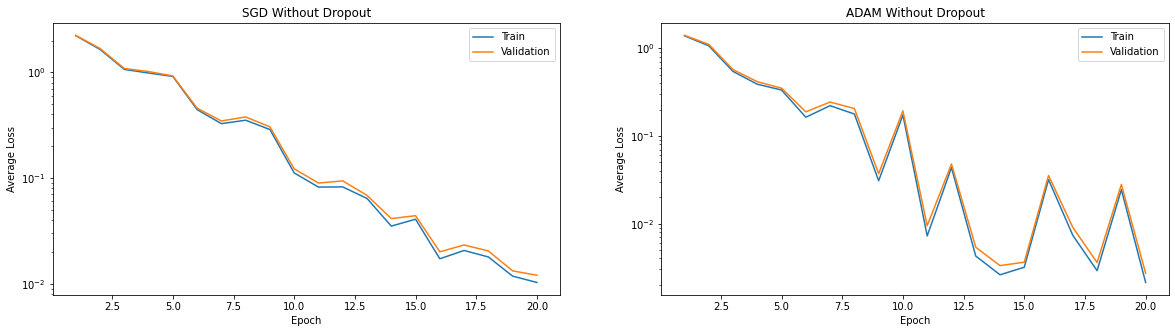

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plt.sca(axs[0])
plt.plot(range(1,21), nn_opt1.train_loss, label = 'Train')
plt.plot(range(1,21), nn_opt1.validation_loss, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('SGD Without Dropout')
plt.legend()
plt.yscale('log')

plt.sca(axs[1])
plt.plot(range(1,21), nn_opt2.train_loss, label = 'Train')
plt.plot(range(1,21), nn_opt2.validation_loss, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('ADAM Without Dropout')
plt.legend()
plt.yscale('log')


<div dir="rtl"> <font size="4" face="vazirmatn">    
همان طور که در نمودار بالا مشخص است هر دو الگوریتم در انتها به دقت تقریبا برابری رسیده‌اند و مقدار تابع هزینه بعد از ۲۰ 
epoch
برای هر دو الگوریتم تقریبا یکسان است. پس دو الگوریتم عملکرد تقریبا یکسانی دارند. رفتار الگوریتم
SGD
پایدارتر است و الگوریتم 
ADAM
واریانس بیشتری در روند همگرایی دارد.
الگوریتم SGD،
کاهش
گرادیان را با نرخ یادگیری یکسان برای همه پارامترها اعمال می‌کند ولی الگوریتم ADAM
برای هر پارامتر نرخ یادگیری بهینه را بر اساس تخمین
momentهای
اول و دوم
گرادیان محاسبه می‌کنید.
</font> </div> 

##Part (c)

In [ ]:
model3 = NeuralNetwork(Dropout=True).to(device)
nn_opt3 = nn_optimizer(model3, train_df, validation_df, 20, 32, 1e-3, 'SGD')
nn_opt3.fit()

Epoch 1
-------------------------------
loss: 4.338156  [    0/20591]
loss: 3.183236  [ 3200/20591]
loss: 3.169509  [ 6400/20591]
loss: 3.217654  [ 9600/20591]
loss: 3.201615  [12800/20591]
loss: 3.101142  [16000/20591]
loss: 3.133195  [19200/20591]
Train Accuracy: 11.3%, Avg Train loss: 2.956572
Validation Accuracy: 10.7%, Avg Validation loss: 2.968009
**************************************************
Epoch 2
-------------------------------
loss: 2.905660  [    0/20591]
loss: 3.084080  [ 3200/20591]
loss: 3.043393  [ 6400/20591]
loss: 2.858373  [ 9600/20591]
loss: 2.949528  [12800/20591]
loss: 2.684290  [16000/20591]
loss: 2.893176  [19200/20591]
Train Accuracy: 13.4%, Avg Train loss: 2.698163
Validation Accuracy: 12.6%, Avg Validation loss: 2.715725
**************************************************
Epoch 3
-------------------------------
loss: 2.777837  [    0/20591]
loss: 2.716952  [ 3200/20591]
loss: 2.749418  [ 6400/20591]
loss: 2.939020  [ 9600/20591]
loss: 2.664087  [12800/205

In [ ]:
model4 = NeuralNetwork(Dropout=True).to(device)
nn_opt4 = nn_optimizer(model4, train_df, validation_df, 20, 32, 1e-4, 'ADAM')
nn_opt4.fit()

Epoch 1
-------------------------------
loss: 5.162931  [    0/20591]
loss: 3.228660  [ 3200/20591]
loss: 3.187814  [ 6400/20591]
loss: 3.097723  [ 9600/20591]
loss: 3.157613  [12800/20591]
loss: 3.115940  [16000/20591]
loss: 3.096901  [19200/20591]
Train Accuracy: 8.8%, Avg Train loss: 3.006510
Validation Accuracy: 8.4%, Avg Validation loss: 3.014140
**************************************************
Epoch 2
-------------------------------
loss: 3.144196  [    0/20591]
loss: 3.082688  [ 3200/20591]
loss: 2.966612  [ 6400/20591]
loss: 3.103886  [ 9600/20591]
loss: 2.753289  [12800/20591]
loss: 2.893552  [16000/20591]
loss: 2.816657  [19200/20591]
Train Accuracy: 18.3%, Avg Train loss: 2.501607
Validation Accuracy: 17.9%, Avg Validation loss: 2.509043
**************************************************
Epoch 3
-------------------------------
loss: 2.795648  [    0/20591]
loss: 2.384871  [ 3200/20591]
loss: 2.489462  [ 6400/20591]
loss: 2.501500  [ 9600/20591]
loss: 2.522877  [12800/20591

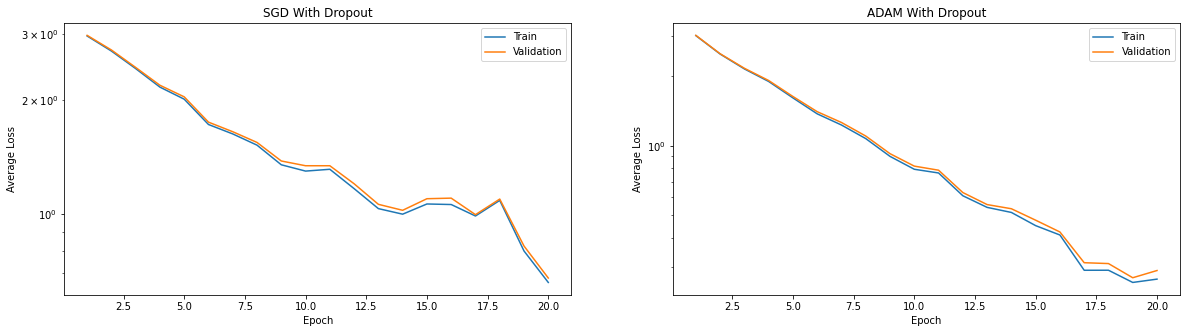

In [ ]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

plt.sca(axs[0])
plt.plot(range(1,21), nn_opt3.train_loss, label = 'Train')
plt.plot(range(1,21), nn_opt3.validation_loss, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('SGD With Dropout')
plt.legend()
plt.yscale('log')

plt.sca(axs[1])
plt.plot(range(1,21), nn_opt4.train_loss, label = 'Train')
plt.plot(range(1,21), nn_opt4.validation_loss, label = 'Validation')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('ADAM With Dropout')
plt.legend()
plt.yscale('log')


<div dir="rtl"> <font size="4" face="vazirmatn">    
همان‌طور که واضح است 
Dropout
باعث رفتار پایدارتر کاهش خطا در هر دو الگوریتم شده است و نوسانات ترم خطا را کاهش داده است که مطابق انتظار است ولی 
با توجه به این‌که مدل مسئله ساده است و تعداد پارامترها آن‌قدر زیاد نیست
Dropout
خروجی نهایی مدل برای هر دو الگوریتم بهینه‌سازی را بدتر کرده است. اگر مدل را پیچیده‌تر می‌کردیم احتمالا تاثیر 
dropout
در بهبود خروجی نهایی نیز دیده می‌شد. 
</font> </div> 

##Part (d)
SGD without Dropout: (Best Model)

In [ ]:
test_dataset = CustomDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)
loss, accuracy = nn_opt1.evaluate(test_dataloader ,'Test')

Test Accuracy: 80.2%, Avg Test loss: 0.828344


ADAM without Dropout:

In [ ]:
loss, accuracy = nn_opt2.evaluate(test_dataloader ,'Test')

Test Accuracy: 79.6%, Avg Test loss: 1.075673


SGD with Dropout:

In [ ]:
loss, accuracy = nn_opt3.evaluate(test_dataloader ,'Test')

Test Accuracy: 63.5%, Avg Test loss: 1.186044


ADAM with Dropout:

In [ ]:
loss, accuracy = nn_opt4.evaluate(test_dataloader ,'Test')

Test Accuracy: 70.2%, Avg Test loss: 1.262215


##Part (e)

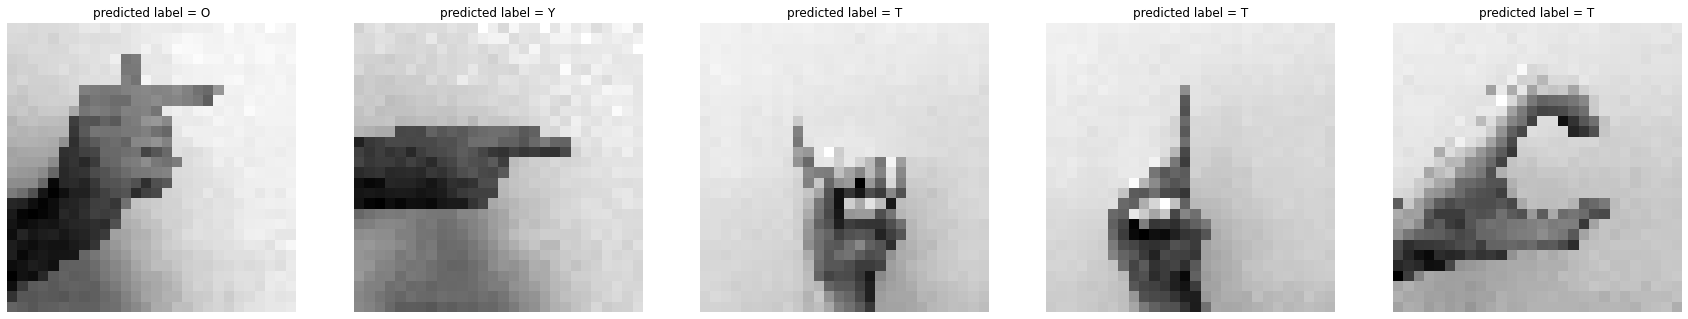

In [ ]:
fig, ax = plt.subplots(ncols= 5, figsize=(30, 10))
imgs = [read_image("/content/drive/My Drive/Data/HW2_data/img1.jpg"),
        read_image("/content/drive/My Drive/Data/HW2_data/img2.jpg"),
        read_image("/content/drive/My Drive/Data/HW2_data/img7.jpg"),
        read_image("/content/drive/My Drive/Data/HW2_data/img10.jpg"),
        read_image("/content/drive/My Drive/Data/HW2_data/img11.jpg")]

gray = T.Grayscale()
resize = T.Resize(size = (28,28))

for i in range(5):
    imgs[i] = gray(imgs[i]).float()
    imgs[i] = resize(imgs[i])
    imgs[i] = imgs[i].squeeze()
    ax[i].axis(False)
    ax[i].imshow(imgs[i], cmap="gray")
    pred = model1(imgs[i].reshape(1, -1).to(device))
    ax[i].set_title('predicted label = ' + chr(pred.argmax() + 65))

fig.show()

<div dir="rtl"> <font size="4" face="vazirmatn">    
متاسفانه در داده زنده نتایج خوبی چه با نرمال کردن عکس و چه بدون آن بدست نیامد. احتمالا دلیل آن تنظیم نبودن نور عکس‌های گرفته شده می‌باشد.
</font> </div> 